In [ ]:
!pip install transformers
import torch
#from longformer.longformer import Longformer, LongformerConfig # This is deprecated
#from longformer.sliding_chunks import pad_to_window_size # This is deprecated
!pip install datasets transformers
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
!pip install scikit-learn
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
import torch
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer
from transformers import LongformerModel, LongformerConfig
from transformers import LongformerTokenizer, LongformerForSequenceClassification
# model = LongformerModel.from_pretrained("allenai/longformer-base-4096")
# The above line downloads the model using 'transformers' package, so there's no need for the separate 'longformer' package.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


tokenization

In [ ]:
# Load the CSV files
train_df = pd.read_csv('/content/dataset_train_updated.csv')
test_df = pd.read_csv('/content/dataset_test_updated.csv')

# Initialize the tokenizer and model for Longformer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=len(train_df['class'].unique()))

# Tokenization function for Longformer
def tokenize_function(examples):
    return tokenizer(
        examples['text'],  # Replace 'text' with the appropriate column name in your dataframe if different
        padding="max_length",
        truncation=True,
        max_length=4096,  # Longformer's max token limit
        return_tensors="pt"  # Return PyTorch tensors
    )


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training

In [ ]:
# Split train_df into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], train_df['class'], test_size=0.1, random_state=42
)
# Create DataFrame for validation set
val_df = pd.DataFrame({'text': val_texts, 'class': val_labels})
# Convert to Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'class' to 'labels' explicitly
if 'class' in train_dataset.column_names:
    train_dataset = train_dataset.rename_column('class', 'labels')
if 'class' in val_dataset.column_names:
    val_dataset = val_dataset.rename_column('class', 'labels')
if 'class' in test_dataset.column_names:
    test_dataset = test_dataset.rename_column('class', 'labels')


# Convert to PyTorch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define training arguments with mini-batching (gradient accumulation)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=20,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    remove_unused_columns=False
)
# Initialize the EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Stop training after 3 evaluation steps with no improvement
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Validation dataset
    callbacks=[early_stopping_callback]
)

# Train the model
torch.cuda.empty_cache()
trainer.train()

# Save the trained model
model.save_pretrained("longformer_finetuned")

# Save the tokenizer as well
tokenizer.save_pretrained("longformer_finetuned")

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Initializing global attention on CLS token...


Epoch,Training Loss,Validation Loss
0,0.699700,0.698608
1,0.693500,0.682874
2,0.674600,0.642163
3,0.595300,0.419571
4,0.479500,0.421828
5,0.366000,0.344923
6,0.349400,0.265825
7,0.348900,0.207940
8,0.715000,0.033103
9,0.168900,0.177884


('longformer_finetuned/tokenizer_config.json',
 'longformer_finetuned/special_tokens_map.json',
 'longformer_finetuned/vocab.json',
 'longformer_finetuned/merges.txt',
 'longformer_finetuned/added_tokens.json')

test

Test Accuracy: 87.00%


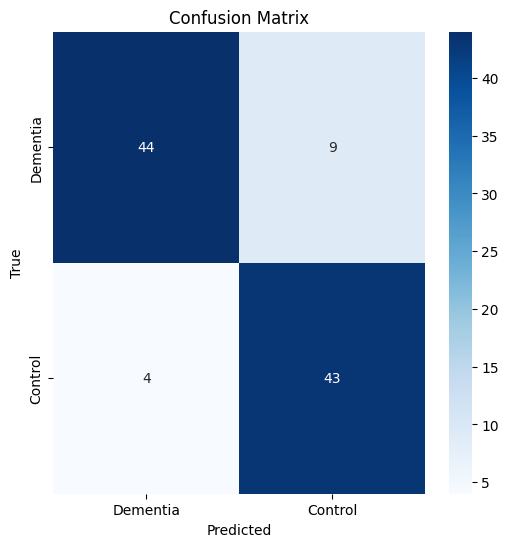

Model training complete, and predictions saved to dataset_test_predictions.csv


In [ ]:
# Make predictions on the test dataset
test_predictions = trainer.predict(test_dataset)

# Get the predicted labels (class) from the logits
predicted_labels = torch.argmax(torch.tensor(test_predictions.predictions), axis=-1)

# Add the predictions to the test dataframe
test_df['predicted_class'] = predicted_labels.numpy()

# Calculate accuracy
true_labels = test_df['class'].values
accuracy = accuracy_score(true_labels, predicted_labels.numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels.numpy())

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dementia", "Control"], yticklabels=["Dementia", "Control"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the predictions with accuracy
test_df.to_csv('dataset_test_predictions.csv', index=False)

print("Model training complete, and predictions saved to dataset_test_predictions.csv")